In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from google.colab import files, drive
from pathlib import Path
import io, os
import pickle
import pyarrow.parquet as pq
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)



import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from scipy.stats import uniform, randint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [ ]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


In [7]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/
!ls ./amostra_news_integrada/amostra_5


/gdrive/My Drive/Colab Notebooks
test.csv  train.csv  valid.csv


In [ ]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [31]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None, vetorPalavras=None, n_top=1000):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  if vetorPalavras==None:
    count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams, max_features=n_top) 
  else:
    count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams, vocabulary=vetorPalavras, max_features=n_top)
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X).vocabulary_
  return [matriz_sparsa,vocabulario]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= PCA(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1),n_top=1000, localDestinoVocabulario=None):
  arquivoVetores = 'count_vector.pkl'
  if localDestinoVocabulario==None or Path(localDestinoVocabulario+"/"+arquivoVetores).is_file()==False:
    vetorPalavras=None
  else:
    vetorPalavras = carregaEstrutura(localDestinoVocabulario, arquivoVetores)
    if not vetorPalavras:
      vetorPalavras=None
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X = X,pct_min = min_fr,pct_max = max_fr,n_grams = ngrams,vetorPalavras = vetorPalavras,n_top = n_top)
  if localDestinoVocabulario!=None:
    salvaEstrutura(vetores[1],localDestinoVocabulario,arquivoVetores)
  V = vetores[0]
  return V

def calcula_especificidade(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = np.sum(VN)/(np.sum(VN) + np.sum(FP))
  return TVN

def calcula_especificidade_porClasse(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = (VN)/(VN + FP)
  return TVN

def calcula_GMean_multiclass(revocacao):
   revoc = np.array(revocacao)
   GMean = revoc.prod()**(1.0/len(revoc))
   return GMean 

def elabora_relatorio_metricas(report, matriz_confusao):
  espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
  dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
  dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
  dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
  dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
  dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
  metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
  df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
  df['support'] = df['support'].astype('int')
  return df

def imprimeMetricas(y_pred, y_true, caminho_destino):
  relatorio = ""
  print('Classification Report:')
  n_classe = np.max(y_true)+1 #obtem o número de classes
  report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) #gera o relatório de métricas
  cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe)) #gera a matriz de confusao
  report = elabora_relatorio_metricas(report, cm) #inclui no relatorio a especificidade
  
  print(report)

  acuracia_score = accuracy_score(y_true, y_pred)
  cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
  ccmatheus = matthews_corrcoef(y_true, y_pred)
  Gmean = calcula_GMean_multiclass(report['recall'])
  acuracia_balanceada = balanced_accuracy_score(y_true, y_pred)

  print("Acurácia:",acuracia_score)
  print('Acurácia balanceada:',acuracia_balanceada)
  print('GMean:', Gmean)
  print('Cohen Kappa Score:', cohen_kappa)
  print('Coef. Correlacao Matheus:', ccmatheus)
  
  y = caminho_destino.split('/')
  arquivo = y[-1:][0].split('.')[0]
  report.to_csv('/'.join(y[:-1]) + '/' + arquivo + ".csv", index=None)
  outrasMetricas  = "Acurácia:" + str(acuracia_score)
  outrasMetricas  += '\n Acurácia balanceada:' + str(acuracia_balanceada)
  outrasMetricas  += '\n GMean:' + str(Gmean)
  outrasMetricas  += '\n Cohen Kappa Score:' + str(cohen_kappa)
  outrasMetricas  += '\n Coef. Correlacao Matheus:' + str(ccmatheus)
  
  
  salvaEstrutura(outrasMetricas, '/'.join(y[:-1]), y[-1:][0])
  

def salvaEstrutura(estrutura, local, arquivo):
  print('***SALVANDO***')
  print(local + "/" + arquivo)
  pickle.dump(estrutura,open(local + "/" + arquivo,'wb'))

def carregaEstrutura(local, arquivo):
  estrutura = pickle.load(open(local + "/" + arquivo,'rb'))
  return estrutura

# Prepara dataset para classificação com algoritmos clássicos

In [10]:
#dfDados = pd.read_csv('news_integradas.csv')
dfTreino = pd.read_csv('./amostra_news_integrada/amostra_5/train.csv')
dfvalidacao = pd.read_csv('./amostra_news_integrada/amostra_5/valid.csv')
dfteste = pd.read_csv('./amostra_news_integrada/amostra_5/test.csv')
dfteste = pd.concat([dfvalidacao, dfteste], sort=False)
print(dfTreino.shape, dfteste.shape)

(15396, 2) (3849, 2)


10


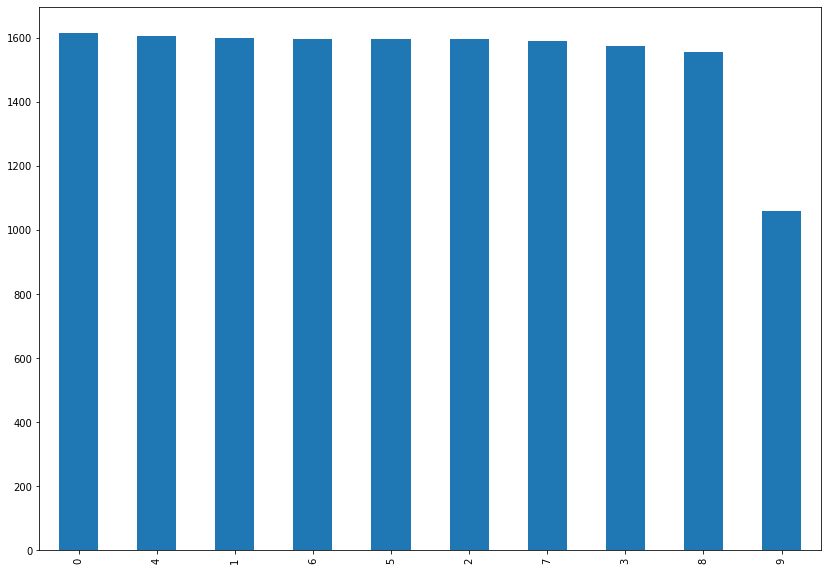

In [ ]:
df = dfTreino['category_nro'].value_counts()
print(dfTreino['category_nro'].unique().size)
df.plot.bar(figsize=(14,10))
#'politica', 'economia', 'esporte', 'mundo', 'ilustrada', 'midia', 'tecnologia', 'educação', 'saude', 'ciencia'

In [11]:
%%time
dfPreProc = PreProcessamentoParalelo(dfTreino,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfTreino)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data]   Unzipping stemmers/rslp.zip.
CPU times: user 1.41 s, sys: 432 ms, total: 1.84 s
Wall time: 3min 52s


In [12]:
print(dfPreProc.shape)
dfPreProc.head()

(15396, 2)


,text,category_nro
0,pouc ano vinic lanz encontr reaç chor prov result decepç ent ano isolous vesti mergulh desol profund enquant lágr corr rost míser cinc cent jog rio dentr própri estádi aquá olímp pouc mes sedi megaevent espor exempl vid nat replet vir part dest terç lanz chanc promov trezent setent set dia após frustr sele olímp cheg troféu mar lenk prim grand event nat nacion cicl melhor temp entr m borbolet eliminatór final nest terç tornei parqu aquá mar lenk dentr parqu olímp classificatóri mund budap julh vai marc pass bast geraçesthiag per exempl aposentous abril enquant país vê surg nom lanz outr ter ido jog bom mant fog brig vag final medalh tóqui diz min hoj ano represent min tênil club medalh prat campeonat mund júni cingap m borbolet lanz adot eua bas iníci estabeleceus bloomington est indi ond pass nad univers local estud veterinár institu pass ser orient ray looz técn integr seleç norteameric rio guru lilly king cody mill blak pieron tod medalh jog nest tempor nad brasil eleit capitã tim universit ray diss vin quer olimpí agor olh pra frent cont nad vag budap dev corrobor técn diss perd olimpí cinc cent aind machuc fez mant foc mai mudanç atitud resum luiz altam viv experi difer consegu classific jog rio prov m livr revez x m livr pass prim fas ambas nad reconhec aprend pod ser interess rum olimpí tóqui obje agor nest cicl tent fic melhor mund precis trein bast natur rora transfer flameng pinh nest tempor club paulist divid rai gabriel sant jog rio nad revez x m livr pedr card perd olimpí pouc fic terc m peit boa marc pinh readquir ces ciel nad vitori histór país mud filosof dispens medalh olímp brun fratu joã lucc apost nov safr perceb hor mud mental afirm técn princip club albert pint silv outr bom val est troféu mar lenk brandonn alme nad m medley m livr rio dev mud eua compet fund guilherm cost abril bat record sulameric m livr esper estabelecers expo ger confi mar lenk consegu melhor temp vou mund diss cris cois abal confianç promess situ turbulent pass cbd confeder brasil desport aquá acus corrupç quatr dirig pres mei entidad perd patrocíni brad viu despenc aport feit correi invest vai diminu bast vai ser dificuldad grand nov ger busc nov competiç lá afirm luiz altam nad diss esper nov gest transpar melhor melhor man ter credibil nov mud tud pens estratég busc nov patrocin renov palavr cert complement altam viníc lanz acris abat sobr confeder trist vai afet ger sobr dirig pres afirm justiç decid event troféu mar lenk terçaf eliminatór h final h m borbolet feminin masculin m livr f m m peit f m x m livr f m quartaf eliminatór h final h m cost f m m medley f m m livr f m livr m quintaf eliminatór h final h m livr f m m peit fem m cost f m m borbolet f m sextaf eliminatór h final h m medley f m m livr f m m cost f m m borbolet f m x m livr f m sáb eliminatór h final h m peit f m m livr f m m livr f m livr m x m medley f m,2
1,situ financ paul apes restriç desp lig aument arrecad registr recent delic secret fazend luil arrob martim diz arrecad icm impost sobr circul mercad prim semestr dev ser ncr milh r bilh fic ncr milh r bilh qued além distanci previs orçamentár govern est reduz desej orç secret educ seguranç públic,6
2,dezen milh pesso particip nest quartaf franç dia protest convoc sindic estud contr reform lei trabalh país impulsion govern ato respost intenç presid françoil holland permit empr mud jorn trabalh funcion além hor seman determin lei remuner adic nov model trabalh pod trabalh hor diár hor seman segu pact sindicat troc funcion pass receb folg extr faz part reform med reduz regr dem trabalh remot noturn med defend govern form reduz tax desempreg franç manifestaç reun trabalh desempreg estud respond cham sindicat mov estudantil protest cidad franc paril númer manifest cheg mil protest dest quart coincid grev funcion ferrov suburb long dist franc provoc atras tr tod país crít reform trabalh irrit mov soc espec porqu suger part social françoil holland ano hav consegu aprov jorn trabalh hor antece

In [13]:
dfPreProc_Teste = PreProcessamentoParalelo(dfteste,mp.cpu_count())
print(dfPreProc_Teste.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
(3849, 2)


In [14]:
V = processaVetorizacao(dfPreProc,min_fr=0.01, max_fr=0.9, ngrams=(1,1),n_top=2500)
X_tfidf = retornaMatriztfIdf(V)
y_treino = dfPreProc['category_nro'].values

In [ ]:
X_treino_coseno = 1-cosine_similarity(X_tfidf)

In [15]:
V_teste = processaVetorizacao(dfPreProc_Teste,min_fr=0.01, max_fr=0.9, ngrams=(1,1),n_top=2500) 
X_tfidf_teste = retornaMatriztfIdf(V_teste)
#X_teste_coseno = 1-cosine_similarity(X_tfidf_teste,X_tfidf_teste)
y_teste = dfPreProc_Teste['category_nro'].values

In [16]:
print(X_tfidf.shape, X_tfidf_teste.shape)

(15396, 2500) (3849, 2500)


In [ ]:
dfT = pd.concat([dfTreino, dfteste], sort=False)
dfT = dfT[~dfT['text'].isnull()]
V_ = processaVetorizacao(dfT,min_fr=1, max_fr=1, ngrams=(1,1),n_top=1000000)
print(V_.shape)

(19152, 56954)


In [ ]:
#X_treino_coseno.shape

(15396, 15396)

KNN

In [ ]:
#https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
%%time
knn = KNeighborsClassifier()
distributions = {
    "n_neighbors": randint(low=2, high=10),
    "weights": ["uniform", "distance"],
    "p": uniform(loc=1, scale=2),
    "metric": ["cosine"]
}
clf = RandomizedSearchCV(
    estimator = knn, # algoritmo de AM que queremos ajustar
    param_distributions = distributions, # distribuição dos hiperparâmetros
    n_iter = 50, # Número de hiperparâmetros selecionados
    scoring = "f1_macro", # performance utilizada na cross-validação
    n_jobs = -1, # número de core em paralelo
    cv = 10, # tipo de cross-validação, no nosso caso 10-fold
    verbose = 2,
    random_state = 42
)

search = clf.fit(X_tfidf.toarray(), y_treino)
result_knn = search.cv_results_
search.best_params_


In [52]:
model = KNeighborsClassifier(metric = 'cosine',
                              n_neighbors= 7,
                              p = 1.1128231580542005,
                              weights = 'distance')
model.fit(X_tfidf.toarray(), y_treino)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=7,
                     p=1.1128231580542005, weights='distance')

In [ ]:
#pickle.dump(model,open('./amostra_news_integrada/amostra_5/knn.pkl', "wb"))

In [53]:
y_pred = model.predict(X_tfidf_teste.toarray())


In [54]:
imprimeMetricas(y_pred, y_teste,'./classica_resp/knn_v1.scr')


Classification Report:
          precision    recall  specificity  f1-score  support
0          0.154023  0.174479     0.893795  0.163614      384
1          0.105943  0.102500     0.899681  0.104193      400
2          0.240741  0.289604     0.892888  0.262921      404
3          0.205607  0.155660     0.925547  0.177181      424
4          0.125899  0.089059     0.929688  0.104322      393
5          0.234421  0.196030     0.925131  0.213514      403
6          0.215026  0.205955     0.912072  0.210393      403
7          0.102094  0.095122     0.900262  0.098485      410
8          0.114232  0.172316     0.864664  0.137387      354
9          0.148515  0.164234     0.927832  0.155979      274
accuracy   0.164458  0.164458     0.907162  0.164458        0
Acurácia: 0.16445830085736554
Acurácia balanceada: 0.16449590522993945
GMean: 0.15547758596154299
Cohen Kappa Score: 0.07147347142930438
Coef. Correlacao Matheus: 0.07166709041169161
***SALVANDO***
./classica_resp/knn_v1.scr


In [ ]:
#dfknnv1 = pd.read_csv('./classica_resp/knn_v1.csv')
#print(dfknnv1)
#carregaEstrutura('./classica_resp','knn_v1.scr')


RANDOM FOREST CLASSIFIER

In [68]:
# Numero de árvores na random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 10)]
# Numero de features para considerar em cada split
max_features = ['auto', 'sqrt']
# Número máximo de níveis na árvore
max_depth = [int(x) for x in np.linspace(10, 90, num = 11)]
max_depth.append(None)
#Número mínimo de amostras necessários para dividir um nodo
min_samples_split = [2, 5, 10]
#Número mínimo de amostras requeridas para cada folha
min_samples_leaf = [1, 2, 4]
#Método de seleção de amostras para treinamento de cada árvore
bootstrap = [True, False]

In [69]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier(random_state=42)
clf = RandomizedSearchCV(
    estimator = rf, # algoritmo de AM que queremos ajustar
    param_distributions = random_grid, # distribuição dos hiperparâmetros
    n_iter = 50, # Número de hiperparâmetros selecionados
    scoring = "f1_macro", # performance utilizada na cross-validação
    n_jobs = -1, # número de core em paralelo
    cv = 5, # tipo de cross-validação, no nosso caso 10-fold
    verbose = 2,
    random_state = 42
)

search = clf.fit(X_tfidf.toarray(), y_treino)
result_knn = search.cv_results_
search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 226.6min


In [65]:
model_rf = RandomForestClassifier(n_estimators=500,
                               bootstrap= True,
                               random_state=42)
model_rf.fit(X_tfidf.toarray(), y_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [66]:
y_pred = model_rf.predict(X_tfidf_teste.toarray())

In [67]:
imprimeMetricas(y_pred, y_teste,'./classica_resp/rf_v1.scr')

Classification Report:
          precision    recall  specificity  f1-score  support
0          0.212766  0.052083     0.978644  0.083682      384
1          0.204545  0.045000     0.979704  0.073770      400
2          0.156962  0.153465     0.903338  0.155194      404
3          0.173077  0.021226     0.987445  0.037815      424
4          0.164816  0.491094     0.717014  0.246803      393
5          0.128031  0.327543     0.739118  0.184100      403
6          0.127796  0.099256     0.920778  0.111732      403
7          0.125285  0.134146     0.888340  0.129564      410
8          0.165919  0.104520     0.946781  0.128250      354
9          0.093023  0.014599     0.989091  0.025237      274
accuracy   0.148090  0.148090     0.905343  0.148090        0
Acurácia: 0.1480904130943102
Acurácia balanceada: 0.1442932905609892
GMean: 0.0913462990367465
Cohen Kappa Score: 0.050300286064125954
Coef. Correlacao Matheus: 0.05318378328538461
***SALVANDO***
./classica_resp/rf_v1.scr


MLP Classifier

In [ ]:
mlp =  MLPClassifier(early_stopping=True)
distributions = {'solver': ['adam','sgd'], 
              'hidden_layer_sizes':[(50,50),(100,100)], 
              'activation':['tanh','relu'],
              'alpha':[1e-4, 5e-2],
              'learning_rate':['constant', 'adaptive']}

clf = RandomizedSearchCV(
    estimator = mlp, # algoritmo de AM que queremos ajustar
    param_distributions = distributions, # distribuição dos hiperparâmetros
    n_iter = 50, # Número de hiperparâmetros selecionados
    scoring = "f1_macro", # performance utilizada na cross-validação
    n_jobs = -1, # número de core em paralelo
    cv = 10, # tipo de cross-validação, no nosso caso 10-fold
    verbose = 2,
    random_state = 42
)

search = clf.fit(X_tfidf.toarray(), y_treino)
result_knn = search.cv_results_
search.best_params_

In [ ]:
model_mlp =  MLPClassifier(activation= 'tanh',
                     alpha= 0.05,
                     hidden_layer_sizes= (100, 100),
                     learning_rate= 'adaptive',
                     solver= 'adam',
                     random_state=42, 
                     early_stopping=True)
model_mlp.fit(X_tfidf.toarray(), y_treino)

In [ ]:
y_pred = model_mlp.predict(X_tfidf_teste.toarray())

In [ ]:
imprimeMetricas(y_pred, y_teste,'./classica_resp/mlp_v1.scr')